<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/one_circle.csv
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/Hyderabad.csv
!ls -al data
!wc -l data/*.csv

2025-03-07 23:51:32 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/one_circle.csv [4820/4820] -> "data/one_circle.csv" [1]
2025-03-07 23:51:33 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/Hyderabad.csv [253067/253067] -> "data/Hyderabad.csv" [1]
total 264
drwxr-xr-x 2 root root   4096 Mar  7 23:51 .
drwxr-xr-x 1 root root   4096 Mar  7 23:51 ..
-rw-r--r-- 1 root root 253067 Mar  7 23:51 Hyderabad.csv
-rw-r--r-- 1 root root   4820 Mar  7 23:51 one_circle.csv
  2518 data/Hyderabad.csv
   111 data/one_circle.csv
  2629 total


In [2]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Dropout
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Some functions to plot our points and draw the lines
def plot_points(features, labels, point_size=25, ax=None):
  X = np.array(features)
  y = np.array(labels)
  spam = X[np.argwhere(y==1)]
  ham = X[np.argwhere(y==0)]
  if ax is None:
    p=plt
    p.xlabel('aha')
    p.ylabel('boo')
  else:
    p=ax
    p.set_xlabel('aha')
    p.set_ylabel('boo')
  p.scatter([s[0][0] for s in spam],
            [s[0][1] for s in spam],
            s = point_size,
            color = 'cyan',
            edgecolor = 'k',
            marker = '^')
  p.scatter([s[0][0] for s in ham],
            [s[0][1] for s in ham],
            s = point_size,
            color = 'red',
            edgecolor = 'k',
            marker = 's')
  p.legend(['happy','sad'])

def draw_line(a,b,c, starting=0, ending=3, **kwargs):
  # Plotting the line ax + by + c = 0
  x = np.linspace(starting, ending, 1000)
  plt.plot(x, -c/b - a*x/b, **kwargs)

f = lambda x: int(x[1]>x[0])
def g(Z):
  return np.array([f(i) for i in Z])
def plot_keras_model(X, y, model, ax=None):
  X = np.array(X)
  y = np.array(y)
  plot_step = 0.2
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = g(Z).reshape(xx.shape)
  if ax is None:
    plt.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y)
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
    plt.show()
  else:
    ax.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y, ax=ax)
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))

def plot_torch_model(X, y, model, ax=None):
  X = np.array(X)
  y = np.array(y)
  plot_step = 0.2
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
  Z = g(Z).reshape(xx.shape)
  if ax is None:
    plt.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y)
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
    plt.show()
  else:
    ax.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y, ax=ax)
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))


# Neural Network

Neural network can be seen as compositions of linear classifiers that give rise to nonlinear classifiers.

In low dimensions, the linear classifiers would look like lines or planes, and the nonlinear classifiers would look like complicated curves or surfaces.

Boundary of a perceptron is a straight line (see ch5-6). When combined into neuro-net, the boundary of the NN becomes non-linear.

*Fully connected* architecture: every node in a layer is connected to every (non bias) node in next layer; no connections happen between non-consecutive layers.

See [Back Prop Ninja notes](https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground4.ipynb#scrollTo=-XSSCuvxW5jZ&line=11&uniqifier=1) for gradient caculations.

In [ ]:
# using the alien mood example
alien_dataset = pd.DataFrame({
  'aack':[1,2,0,0,1,1,2,2],
  'beep':[0,0,1,2,1,2,1,2],
  'happy': [0,0,0,0,1,1,1,1]})

X = alien_dataset[['aack', 'beep']]
y = alien_dataset['happy']

In [ ]:
X, y

(   aack  beep
 0     1     0
 1     2     0
 2     0     1
 3     0     2
 4     1     1
 5     1     2
 6     2     1
 7     2     2,
 0    0
 1    0
 2    0
 3    0
 4    1
 5    1
 6    1
 7    1
 Name: happy, dtype: int64)

These points cannot be separated with one straight line. But can be with 2 lines:
* line 1: $6x_a+10x_b-15=0$
* line 2: $10x_a+6x_b-15=0$

Looking at plot below, we can see that sentence can be classified as Happy if both line1 and line2 >=0

From linear examples in previous chapters, we saw that if a word's weight was positive, the word is likely happy... but here the weights are all positive. i.e. the problem here is not linear.

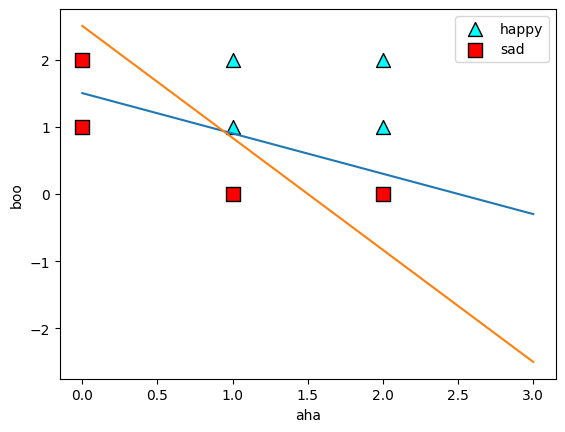

In [ ]:
plot_points(X, y, point_size=100)
draw_line(6,10,-15)
draw_line(10,6,-15)

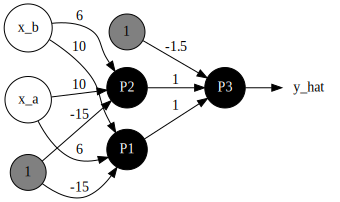

In [ ]:
# the neuro-net
g = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'})
g.node('xa', 'x_a', shape='circle')
g.node('xb', 'x_b', shape='circle')
g.node('b1', '1', shape='circle', style='filled', fillcolor='grey')
g.node('b2', '1', shape='circle', style='filled', fillcolor='grey')
g.node('p1', 'P1', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('p2', 'P2', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('p3', 'P3', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('output', 'y_hat', shape='none')

g.edge('xa', 'p1', label='6')
g.edge('xa', 'p2', label='10')
g.edge('xb', 'p1', label='10')
g.edge('xb', 'p2', label='6')
g.edge('b1', 'p1', label='-15')
g.edge('b1', 'p2', label='-15')

g.edge('p1', 'p3', label='1')
g.edge('p2', 'p3', label='1')
g.edge('b2', 'p3', label='-1.5')

g.edge('p3', 'output')
g

In [ ]:
def step(x):
  if x >= 0:
    return 1
  else:
    return 0

def line_1(a,b):
  return step(6*a + 10*b - 15)

def line_2(a,b):
  return step(10*a + 6*b - 15)

def bias(a,b):
  return 1

def nn_with_step(a,b):
  return step(step(6*a + 10*b - 15) + step(10*a + 6*b - 15) - 1.5)

def sigmoid(x):
  return np.exp(x)/(1.0 + np.exp(x))

def nn_with_sigmoid(a,b):
  return sigmoid(1.0*sigmoid(6*a + 10*b - 15) + 1.0*sigmoid(10*a + 6*b - 15) - 1.5)

def plot_function(f, ax=None):
  plot_points(X, y, 100, ax)

  def h(x,y): # height function of the contour
    return f(x,y)>=0.5
  xx, yy = np.meshgrid(np.arange(-0.5,3,0.005),
                       np.arange(-0.5,3,0.005))
  Z = np.array([h(i[0], i[1]) for i in np.c_[xx.ravel(), yy.ravel()]])
  Z = Z.reshape(xx.shape)
  if ax is None:
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.25, levels=range(-1,2))
    plt.contour(xx, yy, Z,colors = 'k',linewidths = 3)
  else:
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.25, levels=range(-1,2))
    ax.contour(xx, yy, Z,colors = 'k',linewidths = 3)


## Boundaries of NN 1st layer
1st layer of the neuro-net

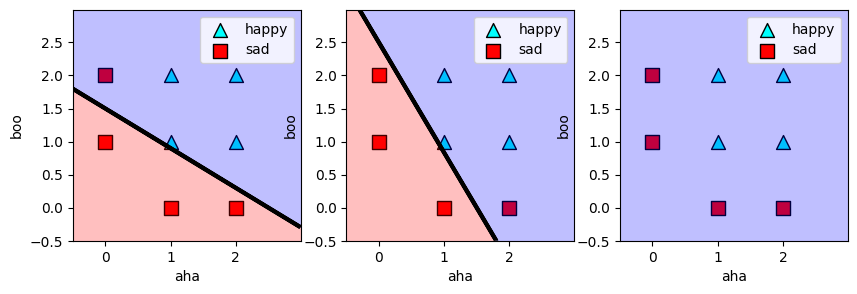

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
plot_function(line_1, ax1)
plot_function(line_2, ax2)
plot_function(bias, ax3)

## Boundaries of NN 2nd layer

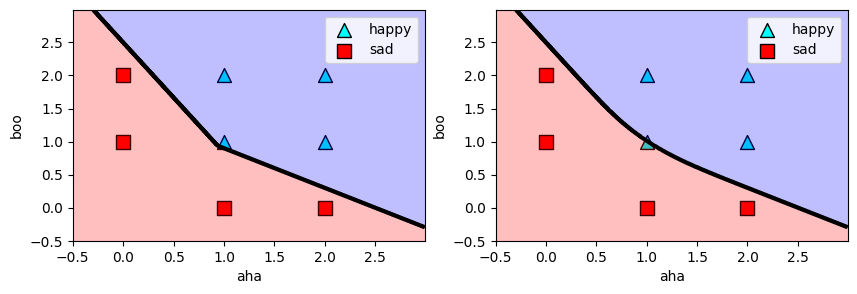

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))
plot_function(nn_with_step, ax1)
plot_function(nn_with_sigmoid, ax2)

# One-Circle Example

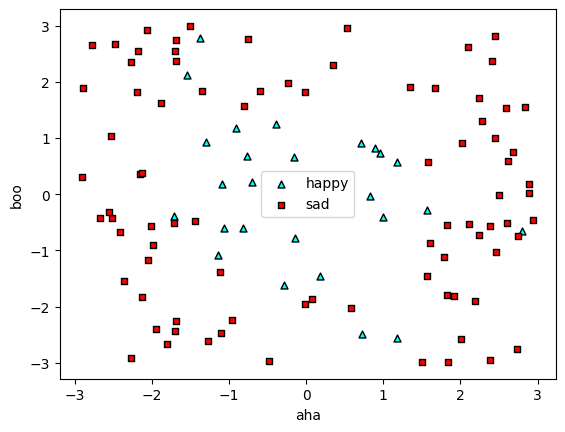

In [ ]:
df = pd.read_csv('data/one_circle.csv', index_col=0)
X = np.array(df[['x_1', 'x_2']])
y = np.array(df['y']).astype(int)
plot_points(X,y)

In [ ]:
X.shape, y.shape

((110, 2), (110,))

## Tensorflow
Implement the example using Tensorflow

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical

# turn y (0 or 1) into one-hot, i.e. [0,1] and [1,0]
categorised_y = np.array(to_categorical(y, 2))

# dimensions of the nero-net
# input: (2,), hidden layer 1 (128,), hidden 2 (64,), output (2,)
# activation fn: hidden layers: ReLU, output layer: Softmax
# dropout in hidden layers, ratio 0.2
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(2,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', # multi-value version of log loss
              optimizer='adam',
              metrics=['accuracy'])

# train the model
model.fit(X, categorised_y, epochs=100, batch_size=10)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5337 - loss: 0.6961  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7576 - loss: 0.4889 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7503 - loss: 0.5231 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7506 - loss: 0.4878 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7439 - loss: 0.4541 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7883 - loss: 0.4359 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7157 - loss: 0.4993 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7734 - loss: 0.4380 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7780 - loss: 0.4389 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7775 - loss: 0.3962 
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8134 - loss: 0.3525 
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,312 (102.79 KB)

 Trainable params: 8,770 (34.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,542 (68.53 KB)

In [ ]:
categorised_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

## PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

class OneCircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(2, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 2)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    # x = F.relu(self.fc3(x))
    x = F.softmax(self.fc3(x), dim=1)
    return x

# prepare data
batch_size=10
categorised_y = F.one_hot(torch.tensor(y), 2).float()
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                        categorised_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# create model
model2 = OneCircleModel()
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model2.parameters(), lr=0.001)
num_epochs = 100
for epoch in range(num_epochs):
  model2.train()

  for features, labels in dataloader:
    outputs = model2(features)
    loss = criterion(outputs, labels)

    # back prop
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  print(f"Epoch [{epoch}/{num_epochs}], loss: {loss.item():.4f}")


Epoch [0/100], loss: 0.6161
Epoch [1/100], loss: 0.5541
Epoch [2/100], loss: 0.4954
Epoch [3/100], loss: 0.5023
Epoch [4/100], loss: 0.5292
Epoch [5/100], loss: 0.5579
Epoch [6/100], loss: 0.5291
Epoch [7/100], loss: 0.5764
Epoch [8/100], loss: 0.4955
Epoch [9/100], loss: 0.6076
Epoch [10/100], loss: 0.6681
Epoch [11/100], loss: 0.4628
Epoch [12/100], loss: 0.4274
Epoch [13/100], loss: 0.6815
Epoch [14/100], loss: 0.6057
Epoch [15/100], loss: 0.3492
Epoch [16/100], loss: 0.4382
Epoch [17/100], loss: 0.4854
Epoch [18/100], loss: 0.3852
Epoch [19/100], loss: 0.5759
Epoch [20/100], loss: 0.6075
Epoch [21/100], loss: 0.5043
Epoch [22/100], loss: 0.4457
Epoch [23/100], loss: 0.5015
Epoch [24/100], loss: 0.3690
Epoch [25/100], loss: 0.4644
Epoch [26/100], loss: 0.3259
Epoch [27/100], loss: 0.4214
Epoch [28/100], loss: 0.4349
Epoch [29/100], loss: 0.4461
Epoch [30/100], loss: 0.4107
Epoch [31/100], loss: 0.4614
Epoch [32/100], loss: 0.3653
Epoch [33/100], loss: 0.4378
Epoch [34/100], loss: 0.

In [ ]:
# pytorch using Sequential
dropout_rate=0.0 # without dropout it's deterministic: the contour plot looks the same every time
model3 = nn.Sequential(
  nn.Linear(2, 128),
  nn.ReLU(),
  nn.Dropout(p=dropout_rate),
  nn.Linear(128, 64),
  nn.ReLU(),
  nn.Dropout(p=dropout_rate),
  nn.Linear(64, 2),
  nn.Softmax(dim=1)
)

criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model3.parameters(), lr=0.001)
for epoch in range(num_epochs):
  model3.train()

  for features, labels in dataloader:
    outputs = model3(features)
    loss = criterion(outputs, labels)

    # back prop
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  print(f"Epoch [{epoch}/{num_epochs}], loss: {loss.item():.4f}")


Epoch [0/100], loss: 0.6418
Epoch [1/100], loss: 0.5074
Epoch [2/100], loss: 0.5868
Epoch [3/100], loss: 0.4232
Epoch [4/100], loss: 0.5099
Epoch [5/100], loss: 0.3489
Epoch [6/100], loss: 0.4642
Epoch [7/100], loss: 0.3658
Epoch [8/100], loss: 0.4918
Epoch [9/100], loss: 0.4523
Epoch [10/100], loss: 0.4756
Epoch [11/100], loss: 0.3401
Epoch [12/100], loss: 0.3828
Epoch [13/100], loss: 0.4412
Epoch [14/100], loss: 0.5201
Epoch [15/100], loss: 0.3825
Epoch [16/100], loss: 0.4063
Epoch [17/100], loss: 0.4033
Epoch [18/100], loss: 0.4597
Epoch [19/100], loss: 0.3428
Epoch [20/100], loss: 0.4155
Epoch [21/100], loss: 0.3556
Epoch [22/100], loss: 0.3663
Epoch [23/100], loss: 0.4301
Epoch [24/100], loss: 0.3643
Epoch [25/100], loss: 0.4954
Epoch [26/100], loss: 0.3848
Epoch [27/100], loss: 0.3248
Epoch [28/100], loss: 0.3164
Epoch [29/100], loss: 0.3315
Epoch [30/100], loss: 0.3719
Epoch [31/100], loss: 0.3717
Epoch [32/100], loss: 0.3338
Epoch [33/100], loss: 0.3780
Epoch [34/100], loss: 0.

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


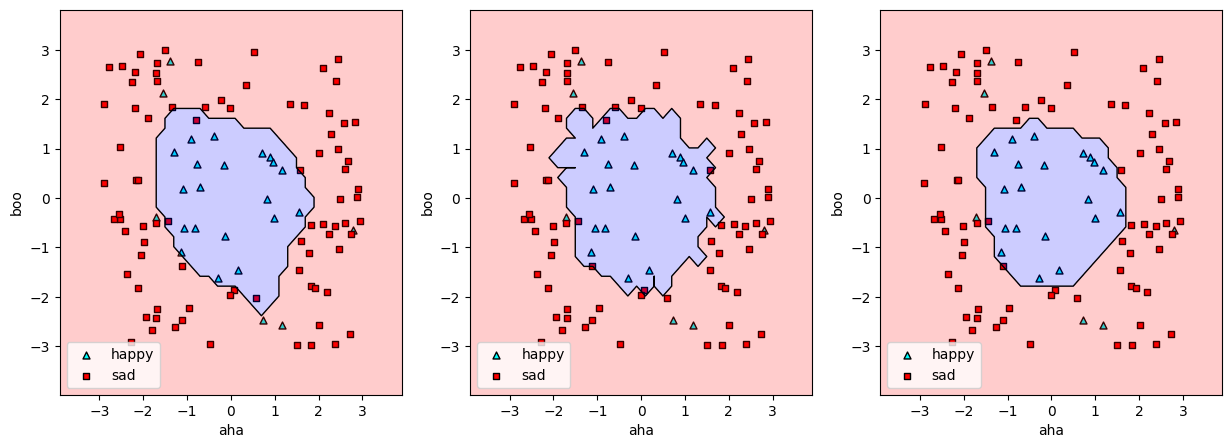

In [ ]:
f = lambda x: int(x[1]>x[0])
def g(Z):
  return np.array([f(i) for i in Z])
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
plot_keras_model(X, y, model, ax1)
plot_torch_model(X, y, model2, ax2)
plot_torch_model(X, y, model3, ax3)

In [ ]:
model(torch.tensor([[-1.0, -3.0]])), model(torch.tensor([[0.0, 0.0]]))

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[9.994223e-01, 5.777252e-04]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.02588455, 0.9741155 ]], dtype=float32)>)

In [ ]:
with torch.no_grad():
  out1 = model2(torch.tensor([[-1.0, -3.0]]))
  out2 = model2(torch.tensor([[0.0, 0.0]]))
  out3 = model3(torch.tensor([[-1.0, -3.0]]))
  out4 = model3(torch.tensor([[0.0, 0.0]]))
out1, out2, out3, out4

(tensor([[9.9999e-01, 6.8210e-06]]),
 tensor([[0.0232, 0.9768]]),
 tensor([[1.0000e+00, 8.9557e-11]]),
 tensor([[1.1796e-04, 9.9988e-01]]))

# MNIST example

## in Tensorflow

In [44]:
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_reshaped = X_train.reshape(-1, 28*28)
X_test_reshaped = X_test.reshape(-1, 28*28)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, \
X_train_reshaped.shape, X_test_reshaped.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 28, 28),
 (60000,),
 (10000, 28, 28),
 (10000,),
 (60000, 784),
 (10000, 784))

In [45]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

y_train_cat.shape, y_test_cat.shape, y_train_cat[0]

((60000, 10), (10000, 10), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

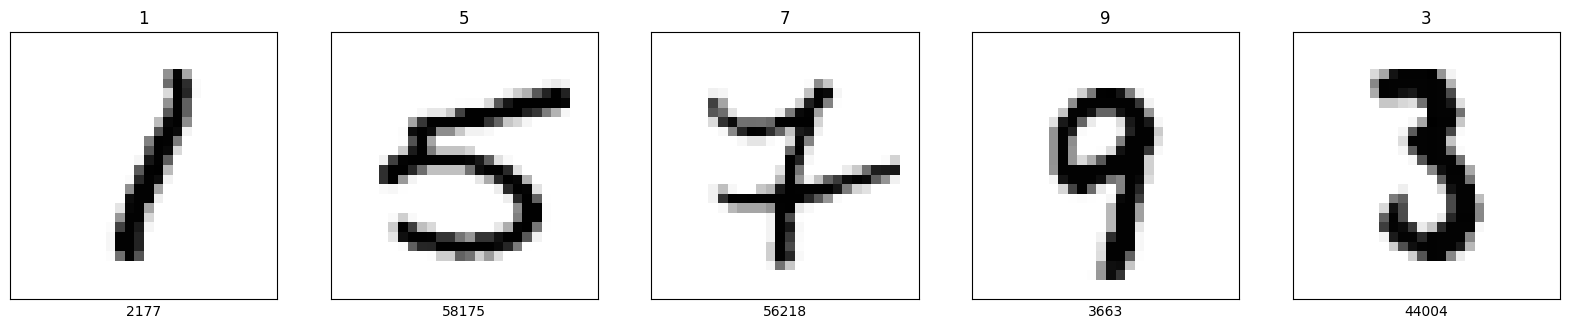

In [46]:
import random
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
for i in range(5):
  idx = random.randint(0, len(X_train))
  ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
  ax.imshow(X_train[idx], cmap='Greys')
  ax.set_title(y_train[idx])
  ax.set_xlabel(idx)

In [49]:
# build the model
import tensorflow.keras
from tensorflow.keras.layers import Dropout, Dense

mnist_model = keras.Sequential()
mnist_model.add(keras.Input(shape=(28*28,)))
mnist_model.add(Dense(128, activation='relu', name='layer1'))
mnist_model.add(Dropout(.2))
mnist_model.add(Dense(64, activation='relu', name='layer2'))
mnist_model.add(Dropout(.2))
mnist_model.add(Dense(10, activation='softmax', name='layer3'))

# Compiling the model
mnist_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mnist_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (Dense)                       │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

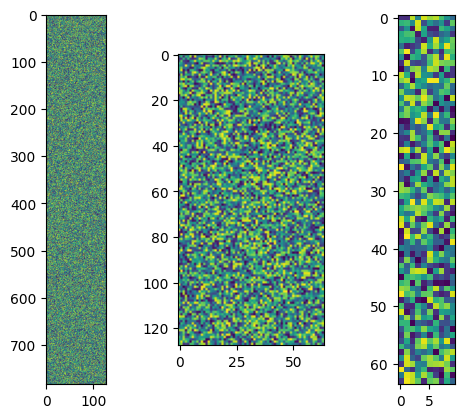

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(mnist_model.get_layer('layer1').get_weights()[0])
ax2.imshow(mnist_model.get_layer('layer2').get_weights()[0])
ax3.imshow(mnist_model.get_layer('layer3').get_weights()[0])

In [52]:
mnist_model.fit(X_train_reshaped, y_train_cat, batch_size=10, epochs=10)

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3948 - loss: 5.5784
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7306 - loss: 0.9370
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8351 - loss: 0.6211
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8686 - loss: 0.5067
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8891 - loss: 0.4347
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8957 - loss: 0.3975
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9026 - loss: 0.3854
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9080 - loss: 0.3780
Epoch 9/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9107 - loss: 0.3581
Epoch 10/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9142 - loss: 0.3479


In [53]:
mnist_model.evaluate(X_test_reshaped, y_test_cat, batch_size=10)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9465 - loss: 0.3303


[0.2732999324798584, 0.954200029373169]

In [54]:
pred_categorical = mnist_model.predict(X_test_reshaped)
preds = [np.argmax(pred) for pred in pred_categorical]
len(preds)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


10000

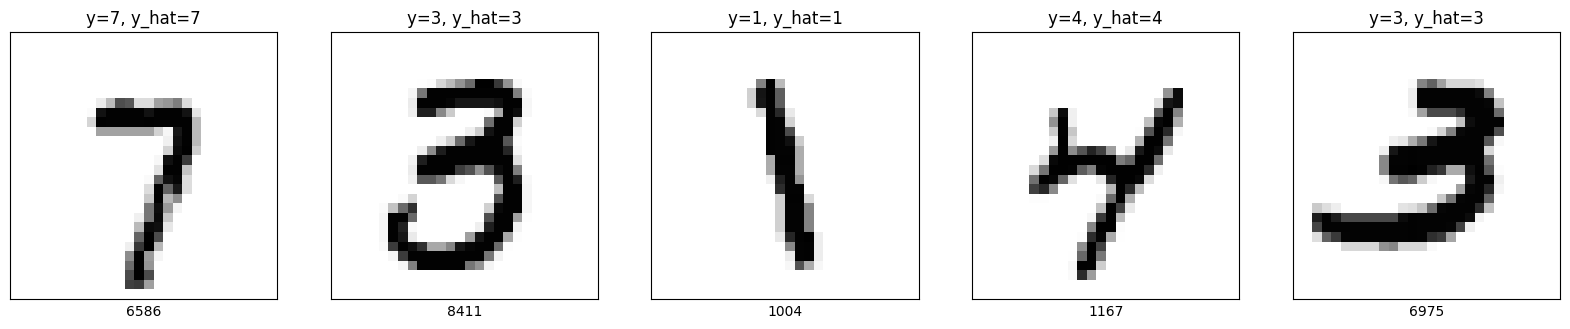

In [55]:
import random
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
for i in range(5):
  idx = random.randint(0, len(X_test))
  cmap='Greys' if y_test[idx]==preds[idx] else 'inferno'
  ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
  ax.imshow(X_test[idx], cmap=cmap)
  ax.set_title(f"y={y_test[idx]}, y_hat={preds[idx]}")
  ax.set_xlabel(idx)

Let's find the wrong predictions and check their confidence.

In [56]:
wrong_idxs = np.where(y_test != preds)[0]
wrong_preds = pred_categorical[wrong_idxs]

right_idxs = np.where(y_test == preds)[0]
right_preds = pred_categorical[right_idxs]

wrong_preds.shape, right_preds.shape

((458, 10), (9542, 10))

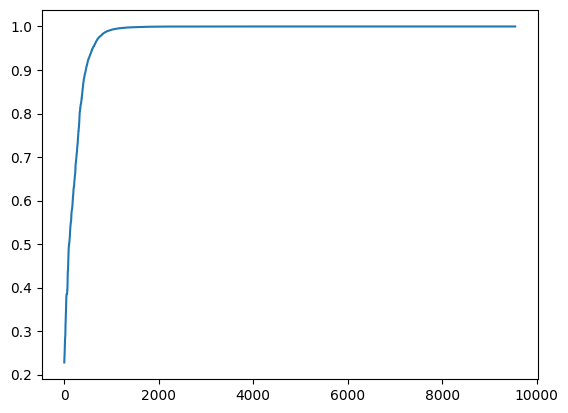

In [57]:
# correct predictions
right_preds_max = right_preds.max(axis=1)
right_preds_max.sort()
plt.plot(right_preds_max)

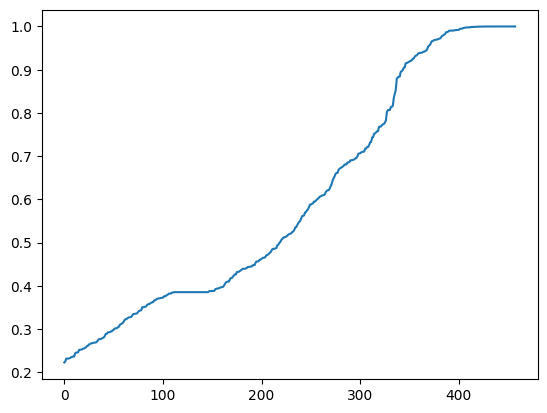

In [58]:
wrong_preds_max = wrong_preds.max(axis=1)
wrong_preds_max.sort()
plt.plot(wrong_preds_max)

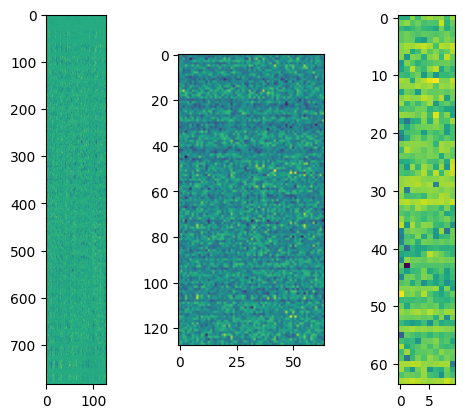

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(mnist_model.get_layer('layer1').get_weights()[0])
ax2.imshow(mnist_model.get_layer('layer2').get_weights()[0])
ax3.imshow(mnist_model.get_layer('layer3').get_weights()[0])

In [86]:
layer1_weights = mnist_model.get_layer('layer1').get_weights()[0]
layer1_weights.T.shape

(128, 784)

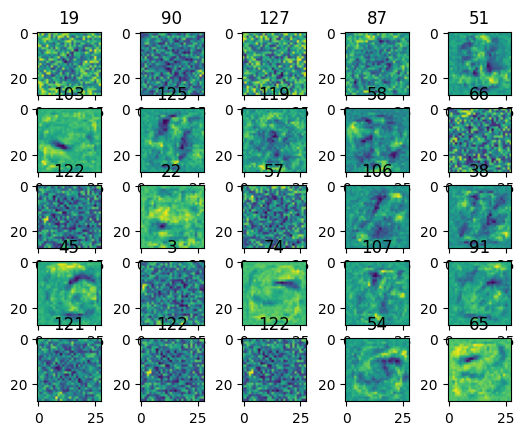

In [147]:
layer1_weights = mnist_model.get_layer('layer1').get_weights()[0].T
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows,ncols)
for i in range(nrows):
  for j in range(ncols):
    # idx = i+i*j
    idx = random.randint(0, 127)
    axes[i,j].imshow(layer1_weights[idx].reshape(28,28))
    axes[i,j].set_title(idx)

## in PyTorch

In [2]:
from torchvision import datasets

trainset = datasets.MNIST(root='./data', train=True, download=True)
smean_train = trainset.data.float().mean() / 255
sstd_train = trainset.data.float().std() / 255
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(trainset.data.min(), trainset.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(trainset.data.float().mean(), trainset.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(trainset.data.float().mean() / 255, trainset.data.float().std() / 255))

testset = datasets.MNIST(root='./data', train=False, download=True)
smean_test = testset.data.float().mean() / 255
sstd_test = testset.data.float().std() / 255
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(testset.data.min(), testset.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(testset.data.float().mean(), testset.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(testset.data.float().mean() / 255, testset.data.float().std() / 255))


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 51.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.0MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.40MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.31842041015625 
Pixel Values Std: 78.56748962402344
Scaled Mean Pixel Value 0.13066047430038452 
Scaled Pixel Values Std: 0.30810779333114624
Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.79122543334961 
Pixel Values Std: 79.17247009277344
Scaled Mean Pixel Value 0.1325146108865738 
Scaled Pixel Values Std: 0.3104802668094635


In [63]:
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((smean_train,), (sstd_train,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((smean_test,), (sstd_test,))
])
# transform = transforms.ToTensor()
dataset_train = datasets.MNIST(root='data', train=True, download=True, transform=transform_train)
dataset_test = datasets.MNIST(root='data', train=False, download=True, transform=transform_test)
dataloader_train = DataLoader(dataset_train, batch_size=10, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1000, shuffle=False)

In [64]:
dropout_rate=0.5
mnist_model2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
    # nn.Softmax(dim=1)
)
mnist_model2

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=64, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)

In [65]:
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import trange, tqdm
# train
num_epochs=10
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimiser = optim.Adam(mnist_model2.parameters(), lr=0.0002)

for epoch in range(1, num_epochs+1):
  mnist_model2.train()

  pbar = tqdm(dataloader_train, desc=f"Epoch {epoch}", leave=True)  # Initialize tqdm progress bar
  for feature, label in pbar:
    pred = mnist_model2(feature)#.squeeze()
    loss = criterion(pred, label)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    # pbar.set_postfix(loss=loss.item())

  print(f"Epoch {epoch}/{num_epochs}, loss={loss:.4f}")


Epoch 1:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 1/10, loss=0.8796


Epoch 2:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 2/10, loss=1.0722


Epoch 3:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 3/10, loss=0.2564


Epoch 4:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 4/10, loss=0.1709


Epoch 5:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 5/10, loss=0.0620


Epoch 6:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 6/10, loss=0.1461


Epoch 7:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 7/10, loss=0.2859


Epoch 8:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 8/10, loss=0.7303


Epoch 9:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 9/10, loss=0.0015


Epoch 10:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 10/10, loss=0.0044


In [66]:
mnist_model2.eval()
with torch.no_grad():
  total_loss = 0
  for feature, label in dataloader_test:
    pred = mnist_model2(feature)
    loss = criterion(pred, label)
    total_loss += loss

  avg_loss = total_loss / len(dataloader_test)
  print(f"Average loss on test dataset: {avg_loss:.4f}")

Average loss on test dataset: 0.1027


In [67]:
with torch.no_grad():
  pred_categorical = mnist_model2(dataset_test.data.to(torch.float32))
  preds = [np.argmax(pred) for pred in pred_categorical.detach().numpy()]
  wrong_idxs = np.where(preds != dataset_test.targets.detach().numpy())[0]

len(preds), wrong_idxs.shape, 1-(wrong_idxs.shape[0] / len(preds))

(10000, (462,), 0.9538)

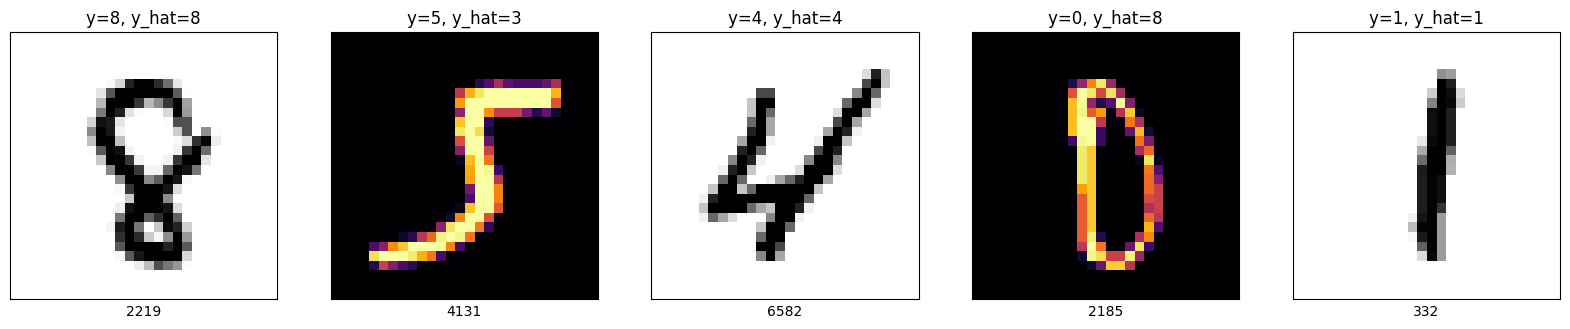

In [68]:
import random
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
for i in range(5):
  idx = random.randint(0, len(dataset_test))
  cmap='Greys' if dataset_test.targets[idx]==preds[idx] else 'inferno'
  ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
  ax.imshow(dataset_test.data[idx], cmap=cmap)
  ax.set_title(f"y={dataset_test.targets[idx]}, y_hat={preds[idx]}")
  ax.set_xlabel(idx)

Examining the values of the softmax, they are either 0 or 1, it means the logits has one partucular very large value compared to other classes. This is very different to tensorflow.

In [69]:
# print the wrong predictions and see how confident they are
for i in wrong_idxs[:20]:
  print(torch.exp(pred_categorical[i]).max())
  # print(pred_categorical[i])

tensor(1.)
tensor(1.)
tensor(0.8929)
tensor(1.)
tensor(1.0000)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.0000)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)


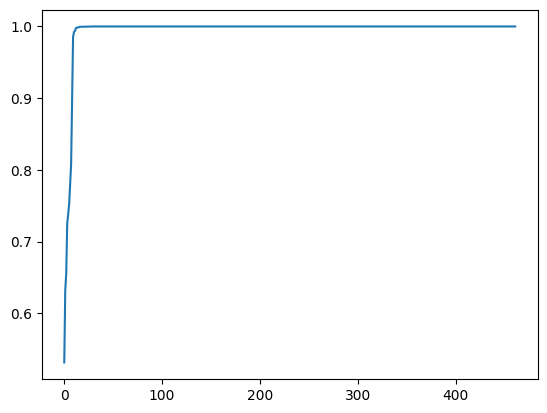

In [70]:
torch_wrong_maxes = torch.exp(pred_categorical[wrong_idxs]).max(axis=1).values.detach().numpy()
torch_wrong_maxes.sort()
plt.plot(torch_wrong_maxes)

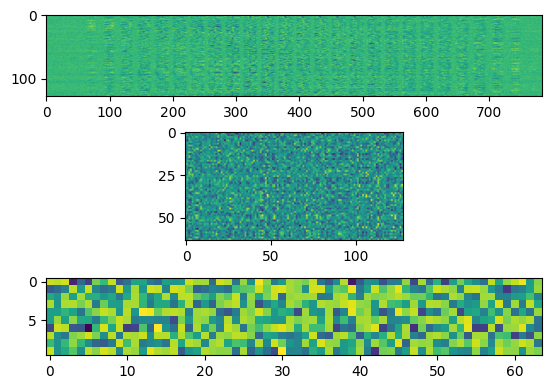

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.imshow(mnist_model2[1].weight.data.detach().numpy())
ax2.imshow(mnist_model2[4].weight.data.detach().numpy())
ax3.imshow(mnist_model2[7].weight.data.detach().numpy())

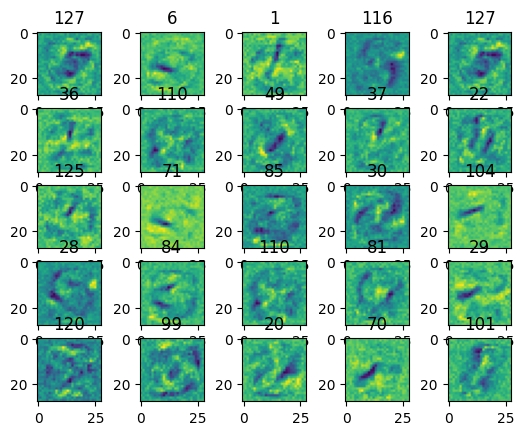

In [144]:
layer1_weights = mnist_model2[1].weight.data.detach().numpy()
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows,ncols)
for i in range(nrows):
  for j in range(ncols):
    # idx = i+i*j
    idx = random.randint(0, 127)
    axes[i,j].imshow(layer1_weights[idx].reshape(28,28))
    axes[i,j].set_title(idx)

## with Temperature

To reduce spikiness of the logits, I will try temperature.

In [108]:
class SimpleNN(nn.Module):
  def __init__(self, temperature=1.0, dropout_rate=0.2):
    super().__init__()
    self.temperature = temperature
    self.dropout_rate = dropout_rate
    self.fc1 = nn.Linear(28*28, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)
    self.dropout = nn.Dropout(p=self.dropout_rate)

  def forward(self, x):
    x = x.view(-1, 28*28) # flatten
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = torch.relu(self.fc2(x))
    x = self.dropout(x)
    logits = self.fc3(x)
    logits = logits / self.temperature
    # probs = torch.softmax(logits, dim=1)
    probs = torch.log_softmax(logits, dim=1)

    return probs

mnist_model3 = SimpleNN(temperature=1., dropout_rate=0.2)
mnist_model3

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

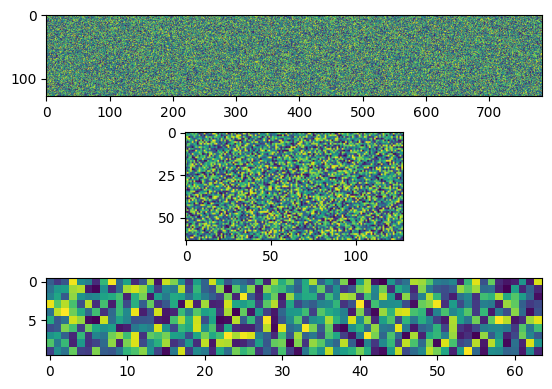

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.imshow(mnist_model3.fc1.weight.data.detach().numpy())
ax2.imshow(mnist_model3.fc2.weight.data.detach().numpy())
ax3.imshow(mnist_model3.fc3.weight.data.detach().numpy())

In [110]:
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import trange, tqdm
# train
num_epochs=10
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimiser = optim.Adam(mnist_model3.parameters(), lr=0.001)

for epoch in range(1, num_epochs+1):
  mnist_model3.train()

  pbar = tqdm(dataloader_train, desc=f"Epoch {epoch}", leave=True)  # Initialize tqdm progress bar
  for feature, label in pbar:
    pred = mnist_model3(feature)#.squeeze()
    loss = criterion(pred, label)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    # pbar.set_postfix(loss=loss.item())

  print(f"Epoch {epoch}/{num_epochs}, loss={loss:.4f}")


Epoch 1:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 1/10, loss=0.0572


Epoch 2:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 2/10, loss=0.1361


Epoch 3:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 3/10, loss=0.0280


Epoch 4:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 4/10, loss=0.4960


Epoch 5:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 5/10, loss=0.0033


Epoch 6:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 6/10, loss=0.0014


Epoch 7:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 7/10, loss=0.0034


Epoch 8:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 8/10, loss=0.0437


Epoch 9:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 9/10, loss=0.1553


Epoch 10:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 10/10, loss=0.0023


In [111]:
mnist_model3.eval()
with torch.no_grad():
  total_loss = 0
  for feature, label in dataloader_test:
    pred = mnist_model3(feature)
    loss = criterion(pred, label)
    total_loss += loss

  avg_loss = total_loss / len(dataloader_test)
  print(f"Average loss on test dataset: {avg_loss:.4f}")

Average loss on test dataset: 0.0919


In [112]:
with torch.no_grad():
  pred_categorical = mnist_model3(dataset_test.data.to(torch.float32))
  preds = [np.argmax(pred) for pred in pred_categorical.detach().numpy()]
  wrong_idxs = np.where(preds != dataset_test.targets.detach().numpy())[0]

len(preds), wrong_idxs.shape, 1-(wrong_idxs.shape[0] / len(preds))

(10000, (395,), 0.9605)

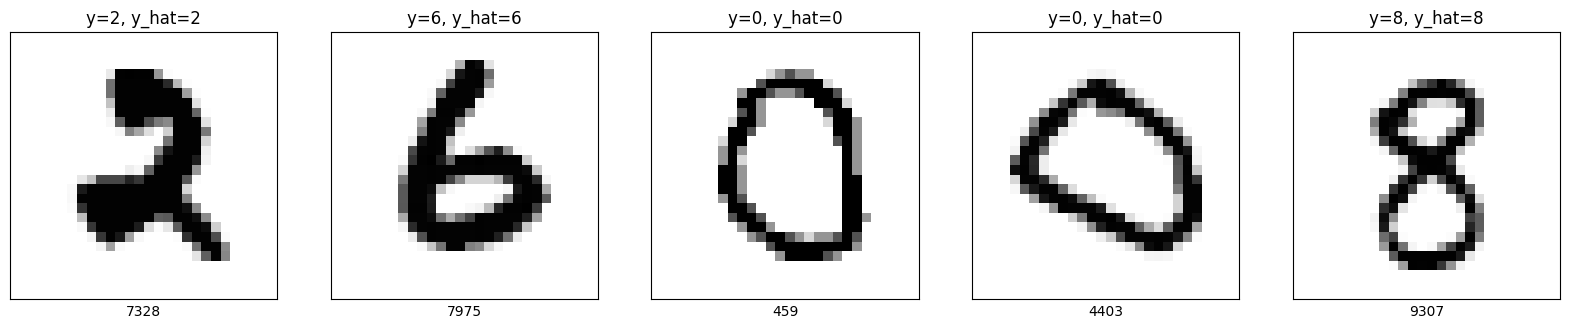

In [113]:
import random
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
for i in range(5):
  idx = random.randint(0, len(dataset_test))
  cmap='Greys' if dataset_test.targets[idx]==preds[idx] else 'inferno'
  ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
  ax.imshow(dataset_test.data[idx], cmap=cmap)
  ax.set_title(f"y={dataset_test.targets[idx]}, y_hat={preds[idx]}")
  ax.set_xlabel(idx)

In [114]:
# print the wrong predictions and see how confident they are
for i in wrong_idxs[:20]:
  print(torch.exp(pred_categorical[i]).max())
  print(torch.exp(pred_categorical[i]))

tensor(1.)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor(1.)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(1.)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 9.2608e-12, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 4.4891e-08, 0.0000e+00])
tensor(1.)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 5.7014e-27,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])
tensor(1.)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.8869e-42, 5.3330e-15])
tensor(1.)
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor(1.)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.2954e-22, 0.0000e+00, 0.0000e+00])
tensor(1.)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(1.)
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor(1.)
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor(1.)
tensor([0., 0., 0., 1., 0., 0., 0., 0

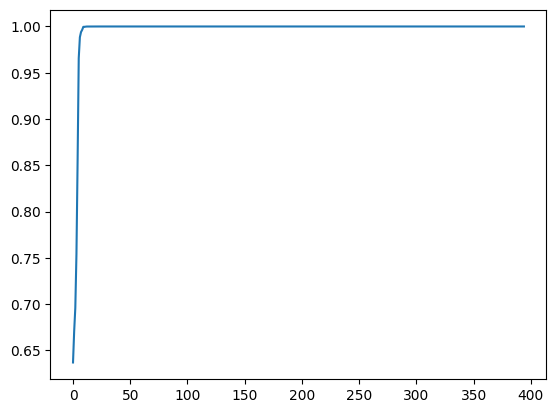

In [115]:
torch_wrong_maxes = torch.exp(pred_categorical[wrong_idxs]).max(axis=1).values.detach().numpy()
torch_wrong_maxes.sort()
plt.plot(torch_wrong_maxes)

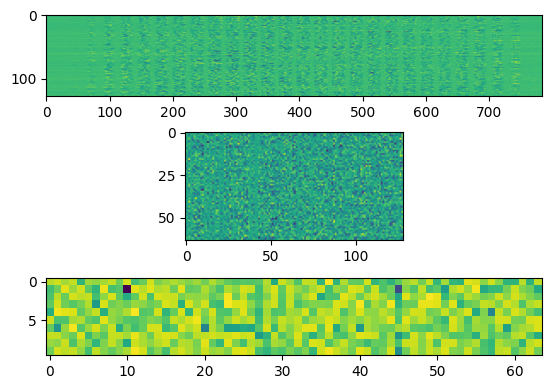

In [116]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.imshow(mnist_model3.fc1.weight.data.detach().numpy())
ax2.imshow(mnist_model3.fc2.weight.data.detach().numpy())
ax3.imshow(mnist_model3.fc3.weight.data.detach().numpy())

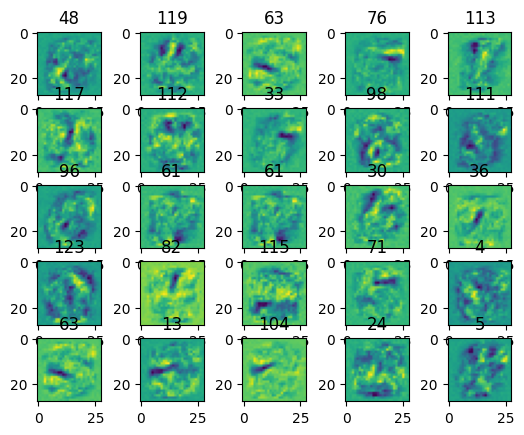

In [143]:
layer1_weights = mnist_model3.fc1.weight.data.detach().numpy()
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows,ncols)
for i in range(nrows):
  for j in range(ncols):
    # idx = i+i*j
    idx = random.randint(0, 127)
    axes[i,j].imshow(layer1_weights[idx].reshape(28,28))
    axes[i,j].set_title(idx)

# Neuro-Net for Regression

To make classification NN into regression NN:
1. remove the final Softmax, so that it outputs any number
2. change the error function to Absolute Error or MSE.

# House price example

In [20]:
df = pd.read_csv('data/Hyderabad.csv')
df

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,11000000,1460,Nacharam,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2514,26000000,1314,Manikonda,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2515,13300000,2625,Madhapur,3,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2516,10800000,2050,Hitech City,3,0,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [21]:
df['Location'].nunique()

243

In [22]:
# turn the location strings into numbers

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
label_encoder = LabelEncoder()
df['Loc'] = label_encoder.fit_transform(df['Location'])
scaler = MinMaxScaler()
# df['Area_scaled'] = scaler.fit_transform(df[['Area']])
# df['Loc_scaled'] = scaler.fit_transform(df[['Loc']])
df

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,Loc
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,0,1,0,0,0,0,0,0,0,162
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,0,1,0,0,0,0,0,0,0,85
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,132
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,11000000,1460,Nacharam,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,150
2514,26000000,1314,Manikonda,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,132
2515,13300000,2625,Madhapur,3,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,124
2516,10800000,2050,Hitech City,3,0,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,85


In [23]:
df.max()

,0
Price,165000000
Area,9400
Location,west venkatapuram
No. of Bedrooms,8
Resale,1
MaintenanceStaff,9
Gymnasium,9
SwimmingPool,9
LandscapedGardens,9
JoggingTrack,9


In [24]:
# features = df.drop(['Location', 'Price', 'Area', 'Loc'], axis=1)
features_unscaled = df.drop(['Location', 'Price'], axis=1)
labels = df['Price'].astype(float)
features = pd.DataFrame(scaler.fit_transform(features_unscaled), columns=features_unscaled.columns)
features

,Area,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,...,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,Loc
0,0.094382,0.142857,0.0,0.0,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,...,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.669421
1,0.336854,0.428571,0.0,0.0,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,...,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351240
2,0.091910,0.142857,0.0,0.0,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.545455
3,0.089326,0.285714,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037190
4,0.072472,0.142857,0.0,0.0,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.487603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,0.107865,0.142857,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.619835
2514,0.091461,0.142857,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.545455
2515,0.238764,0.285714,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.512397
2516,0.174157,0.285714,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.351240


In [25]:
features.max()

,0
Area,1.0
No. of Bedrooms,1.0
Resale,1.0
MaintenanceStaff,1.0
Gymnasium,1.0
SwimmingPool,1.0
LandscapedGardens,1.0
JoggingTrack,1.0
RainWaterHarvesting,1.0
IndoorGames,1.0


In [26]:
from sklearn.model_selection import train_test_split
# Split the DataFrame into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

features.shape, labels.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2518, 39), (2518,), (2014, 39), (504, 39), (2014,), (504,))

## in Tensorflow

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

# Building the model
house_model = Sequential()
house_model.add(Dense(features.shape[1], activation='relu',
                      input_shape=(features.shape[1],), name='input_layer')
                )
house_model.add(Dropout(.2))
house_model.add(Dense(128, activation='relu', name='hidden_1'))
house_model.add(Dropout(.2))
house_model.add(Dense(64, activation='relu', name='hidden_2'))
house_model.add(Dropout(.2))
house_model.add(Dense(1, name='output_layer'))

optimiser = tf.keras.optimizers.Adamax(learning_rate=0.1)
# Compiling the model. The metrics flag is added for the model to report the root mean squared error at each epoch.
house_model.compile(loss = 'mean_squared_error', optimizer=optimiser, metrics=[keras.metrics.RootMeanSquaredError()])
house_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (Dense)                  │ (None, 39)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 39)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_1 (Dense)                     │ (None, 128)                 │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_2 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,001 (58.60 KB)

 Trainable params: 15,001 (58.60 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
house_model.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 140225229619200.0000 - root_mean_squared_error: 11816349.0000
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 78474966466560.0000 - root_mean_squared_error: 8768291.0000
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 76488468594688.0000 - root_mean_squared_error: 8666570.0000
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90119134511104.0000 - root_mean_squared_error: 9140967.0000
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40088583012352.0000 - root_mean_squared_error: 6305725.5000
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 30882924593152.0000 - root_mean_squared_error: 5543813.5000
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 33313297268736.0000 - root_mean_squared_error: 5737610.5000
Epoch 8/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29907040075776.0000 - root_mean_squared_error: 5424484.0000
Epoch 9/100
202/202 ━━━━━━━━━━

In [29]:
house_model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18177970929664.0000 - root_mean_squared_error: 4181768.7500 


[18604426788864.0, 4313285.0]

In [30]:
preds = house_model.predict(X_test)
preds.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


(504, 1)

In [31]:
err = preds.flatten() - y_test.to_numpy()
err_percent = np.abs(((err)/y_test.to_numpy()))
err_percent.sort()
err_percent.min(), err_percent.max()

(0.0020263636363636365, 2.1013804137931036)

In [32]:
rms = tf.sqrt(tf.reduce_mean(tf.square(err)))
rms_percent = rms / tf.reduce_mean(y_test)
rms, rms_percent

(<tf.Tensor: shape=(), dtype=float64, numpy=4313284.855817273>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.44389657239248703>)

Let's examine the weights of the NN and see whether it can give us any indication which column of the CSV file influences the price the most.

In [33]:
input_weights = house_model.get_layer('input_layer').get_weights()[0]
input_biases = house_model.get_layer('input_layer').get_weights()[1]

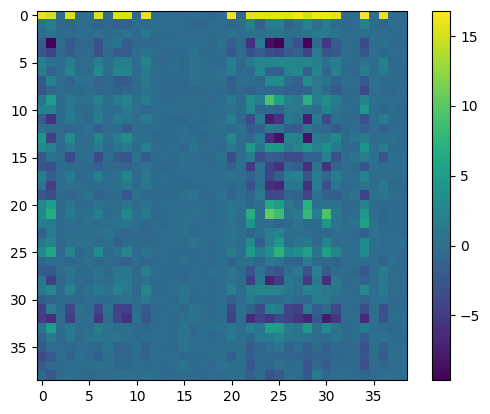

In [34]:
plt.imshow(input_weights)
plt.colorbar()

In [35]:
input_weights[:,0].sum()

0.7823408

In [36]:
np.argsort(input_weights.sum(axis=1))

array([32,  3,  4, 31, 16, 15, 19, 36, 11, 28,  8, 18, 35, 37, 12, 38, 27,
       26, 30,  7, 23,  1, 13,  2, 17, 34, 24, 22, 10,  6, 20, 33,  5, 29,
       14,  9, 25, 21,  0])

In [37]:
features.columns[np.argsort(input_weights.sum(axis=0))]

Index(['GolfCourse', 'ClubHouse', 'ATM', 'CarParking', 'Resale', 'Loc',
       'LiftAvailable', 'SportsFacility', 'Refrigerator', 'Gymnasium',
       'ShoppingMall', 'PowerBackup', 'TV', 'SwimmingPool', 'MultipurposeRoom',
       'JoggingTrack', 'School', '24X7Security', 'Sofa', 'StaffQuarter',
       'Area', 'No. of Bedrooms', 'Hospital', 'Wardrobe',
       'RainWaterHarvesting', 'Gasconnection', 'Microwave', 'AC', 'Cafeteria',
       'DiningTable', 'LandscapedGardens', 'Children'splayarea',
       'VaastuCompliant', 'IndoorGames', 'MaintenanceStaff', 'Wifi',
       'WashingMachine', 'Intercom', 'BED'],
      dtype='object')

In [38]:
features.columns[np.argsort(input_weights.sum(axis=1))]

Index(['GolfCourse', 'MaintenanceStaff', 'Gymnasium', 'Microwave',
       '24X7Security', 'School', 'StaffQuarter', 'Wardrobe', 'Intercom',
       'LiftAvailable', 'RainWaterHarvesting', 'CarParking', 'Sofa',
       'Refrigerator', 'SportsFacility', 'Loc', 'Children'splayarea', 'Wifi',
       'VaastuCompliant', 'JoggingTrack', 'WashingMachine', 'No. of Bedrooms',
       'ATM', 'Resale', 'PowerBackup', 'DiningTable', 'Gasconnection',
       'Hospital', 'ShoppingMall', 'LandscapedGardens', 'Cafeteria', 'TV',
       'SwimmingPool', 'BED', 'ClubHouse', 'IndoorGames', 'AC',
       'MultipurposeRoom', 'Area'],
      dtype='object')

In [39]:
hidden1_weights = house_model.get_layer('hidden_1').get_weights()[0]
hidden1_biases = house_model.get_layer('hidden_1').get_weights()[1]

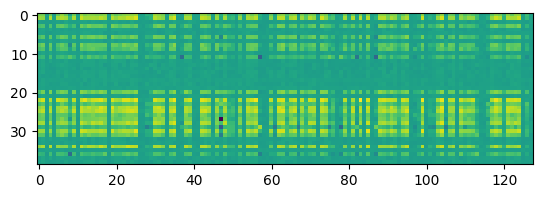

In [40]:
plt.imshow(hidden1_weights)
# plt.colorbar()

In [41]:
hidden1_weights.shape, hidden1_biases.shape

((39, 128), (128,))

In [42]:
features.columns[np.argsort(hidden1_weights.sum(axis=1))]

Index(['ClubHouse', 'Resale', 'Loc', 'SportsFacility', 'JoggingTrack', 'TV',
       'ATM', 'ShoppingMall', 'Sofa', 'CarParking', 'Gymnasium',
       'MultipurposeRoom', '24X7Security', 'SwimmingPool', 'Refrigerator',
       'GolfCourse', 'School', 'StaffQuarter', 'PowerBackup', 'BED',
       'Intercom', 'Wardrobe', 'IndoorGames', 'WashingMachine',
       'MaintenanceStaff', 'RainWaterHarvesting', 'LandscapedGardens',
       'Microwave', 'Wifi', 'Children'splayarea', 'Cafeteria', 'Area',
       'LiftAvailable', 'DiningTable', 'Gasconnection', 'No. of Bedrooms',
       'VaastuCompliant', 'AC', 'Hospital'],
      dtype='object')

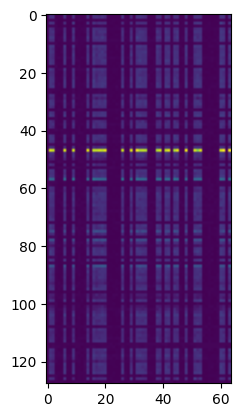

In [43]:
hidden2_weights = house_model.get_layer('hidden_2').get_weights()[0]
hidden2_biases = house_model.get_layer('hidden_2').get_weights()[1]
plt.imshow(hidden2_weights)

## In PyTorch

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

class RMSELoss(nn.Module):
  def __init__(self, eps=1e-6):
    super().__init__()
    self.mse = nn.MSELoss()
    self.eps = eps

  def forward(self,yhat,y):
    loss = torch.sqrt(self.mse(yhat,y) + self.eps)
    return loss

dropout_rate = 0.2
house_model2 = nn.Sequential(
    nn.Linear(features.shape[1], 128),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(64, 1)
)
house_model2

Sequential(
  (0): Linear(in_features=39, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)

In [45]:
batch_size=10
Xt_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
yt_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
Xt_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
yt_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

dataset_train = TensorDataset(torch.tensor(Xt_train, dtype=torch.float32),
                        yt_train)
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# train
num_epochs = 100
criterion = RMSELoss()
optimiser = optim.Adamax(house_model2.parameters(), lr=0.1)
for epoch in range(num_epochs):
  house_model2.train()

  for feature, label in dataloader:
    pred = house_model2(feature).squeeze()
    loss = criterion(pred, label)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  print(f"Epoch [{epoch}/{num_epochs}], loss: {loss.item():.4f}")

<ipython-input-45-bf03516017a5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_train = TensorDataset(torch.tensor(Xt_train, dtype=torch.float32),


Epoch [0/100], loss: 9372237.0000
Epoch [1/100], loss: 21236538.0000
Epoch [2/100], loss: 824199.6875
Epoch [3/100], loss: 5000736.0000
Epoch [4/100], loss: 22790446.0000
Epoch [5/100], loss: 2000384.5000
Epoch [6/100], loss: 2512020.2500
Epoch [7/100], loss: 2231494.5000
Epoch [8/100], loss: 4263160.0000
Epoch [9/100], loss: 4794175.0000
Epoch [10/100], loss: 5510228.5000
Epoch [11/100], loss: 1669107.6250
Epoch [12/100], loss: 3689165.0000
Epoch [13/100], loss: 6201161.5000
Epoch [14/100], loss: 10079921.0000
Epoch [15/100], loss: 7906743.0000
Epoch [16/100], loss: 4430534.5000
Epoch [17/100], loss: 1326675.1250
Epoch [18/100], loss: 3097704.0000
Epoch [19/100], loss: 3657448.2500
Epoch [20/100], loss: 2718773.2500
Epoch [21/100], loss: 2589527.2500
Epoch [22/100], loss: 1857918.8750
Epoch [23/100], loss: 4135487.5000
Epoch [24/100], loss: 2166446.5000
Epoch [25/100], loss: 6138212.5000
Epoch [26/100], loss: 2152533.7500
Epoch [27/100], loss: 9083881.0000
Epoch [28/100], loss: 556188

In [46]:
dataset_test = TensorDataset(torch.tensor(Xt_test, dtype=torch.float32),
                        yt_test)
dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

house_model2.eval()
with torch.no_grad():
  total_loss = 0
  for feature, label in dataloader:
    pred = house_model2(feature).squeeze()
    loss = criterion(pred, label)
    total_loss += loss

  avg_loss = total_loss / len(dataloader)
  print(f"Average RMSE on test dataset: {avg_loss:.4f}")

Average RMSE on test dataset: 3175492.5000


<ipython-input-46-741d035f8d32>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_test = TensorDataset(torch.tensor(Xt_test, dtype=torch.float32),


In [47]:
preds2= house_model2(Xt_test)
err2 = preds2.squeeze() - yt_test
err_percent2 = err2 / yt_test
print(f"min={err_percent2.abs().min()}, max={err_percent2.abs().max()}")
err_percent2 = np.abs(err_percent2.detach().numpy())
err_percent2.sort()


min=0.0003309311287011951, max=2.019996404647827


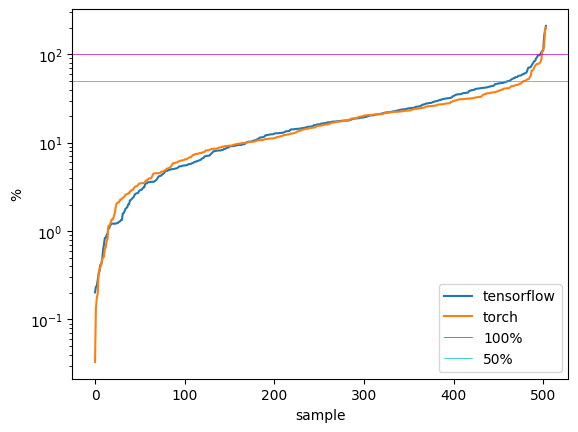

In [48]:
plt.plot(err_percent*100, label='tensorflow')
plt.plot(err_percent2*100, label='torch')
plt.ylabel('%')
plt.yscale('log')
plt.xlabel('sample')
plt.axhline(y=100, color='m', label='100%', lw=0.5)
plt.axhline(y=50, color='c', label='50%', lw=0.5)
plt.legend()

In [49]:
rmse = torch.mean(torch.sqrt(torch.mean(err2**2)))
rmse

tensor(4205896.5000, grad_fn=<MeanBackward0>)

There seems to be some overlapping between the tensorflow and torch networks first layers.

In [50]:
features.columns[np.argsort(house_model2[0].weight.data.sum(axis=0).detach().numpy())]

Index(['MaintenanceStaff', 'GolfCourse', 'StaffQuarter', '24X7Security',
       'LiftAvailable', 'Microwave', 'School', 'SportsFacility', 'Wardrobe',
       'BED', 'Intercom', 'RainWaterHarvesting', 'Loc', 'Gymnasium', 'Wifi',
       'CarParking', 'JoggingTrack', 'VaastuCompliant', 'Sofa', 'Hospital',
       'WashingMachine', 'Refrigerator', 'ShoppingMall', 'Children'splayarea',
       'DiningTable', 'Resale', 'Gasconnection', 'Cafeteria', 'PowerBackup',
       'LandscapedGardens', 'No. of Bedrooms', 'TV', 'SwimmingPool',
       'ClubHouse', 'ATM', 'IndoorGames', 'AC', 'MultipurposeRoom', 'Area'],
      dtype='object')

In [51]:
np.argsort(input_weights.sum(axis=1))

array([32,  3,  4, 31, 16, 15, 19, 36, 11, 28,  8, 18, 35, 37, 12, 38, 27,
       26, 30,  7, 23,  1, 13,  2, 17, 34, 24, 22, 10,  6, 20, 33,  5, 29,
       14,  9, 25, 21,  0])

In [57]:
W=input_weights.sum(axis=1)

In [60]:
W[0], W[21], W[32]

(311.44516, 66.0146, -100.87332)

In [52]:
features.columns[np.argsort(input_weights.sum(axis=1))]

Index(['GolfCourse', 'MaintenanceStaff', 'Gymnasium', 'Microwave',
       '24X7Security', 'School', 'StaffQuarter', 'Wardrobe', 'Intercom',
       'LiftAvailable', 'RainWaterHarvesting', 'CarParking', 'Sofa',
       'Refrigerator', 'SportsFacility', 'Loc', 'Children'splayarea', 'Wifi',
       'VaastuCompliant', 'JoggingTrack', 'WashingMachine', 'No. of Bedrooms',
       'ATM', 'Resale', 'PowerBackup', 'DiningTable', 'Gasconnection',
       'Hospital', 'ShoppingMall', 'LandscapedGardens', 'Cafeteria', 'TV',
       'SwimmingPool', 'BED', 'ClubHouse', 'IndoorGames', 'AC',
       'MultipurposeRoom', 'Area'],
      dtype='object')

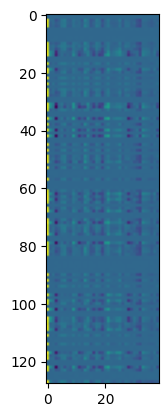

In [53]:
plt.imshow(house_model2[0].weight.data.detach().numpy())

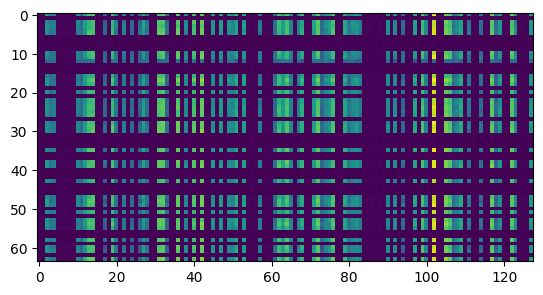

In [54]:
plt.imshow(house_model2[3].weight.data.detach().numpy())

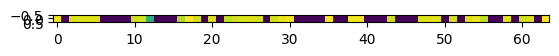

In [55]:
plt.imshow(house_model2[6].weight.data.detach().numpy())

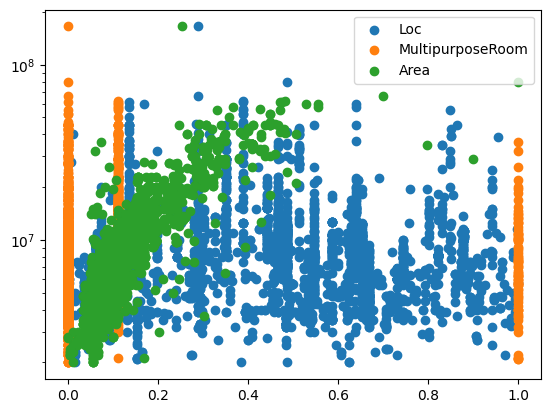

In [68]:
# plt.scatter(df['GolfCourse'], df['Price'])
# plt.scatter(df['MaintenanceStaff'], df['Price'])
# plt.scatter(df['StaffQuarter'], df['Price'])

plt.scatter(features['Loc'], df['Price'], label='Loc')
plt.scatter(features['MultipurposeRoom'], df['Price'], label='MultipurposeRoom')
plt.scatter(features['Area'], df['Price'], label='Area')
plt.yscale('log')
plt.legend()